### Example Implementation
This file goes through every step of the process, using features available to HotDeckImputer.

In [28]:
# from hot_deck_imputer import HotDeckImputer
# Add the src directory to the Python path
import sys
import os

# Import the HotDeckImputer class
from hot_deck_imputer import HotDeckImputer
import polars as pl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#### Generate Data

In [29]:
# Create possibilities for race, sex, and work
race_categories = ['Black', 'White']
sex_categories = ['M', 'F']
work_categories = [0, 1]
np.random.seed(42)  # For reproducibility

# Generate polars frames
donor_data = {
    'donor_assets': np.random.randint(200, 500000, size=1000),
    'race_cell': np.random.choice(race_categories, size=1000),
    'sex_cell': np.random.choice(sex_categories, size=1000),
    'work_cell': np.random.choice(work_categories, size=1000),
    'weight': np.random.randint(1, 5, size=1000)
}

donor_data = pl.DataFrame(donor_data)

recipient_data = {
    'race_cell': np.random.choice(race_categories, size=1500),
    'sex_cell': np.random.choice(sex_categories, size=1500),
    'work_cell': np.random.choice(work_categories, size=1500),
    'weight': np.random.randint(1, 5, size=1500)
}

recipient_data = pl.DataFrame(recipient_data)

#### Create Imputer + Define Cells

In [30]:
imputer = HotDeckImputer(donor_data = donor_data, 
                         imputation_var = 'donor_assets', 
                         weight_var = 'weight', 
                         recipient_data = recipient_data)

In [31]:
# If you are imputing from one dataset to another across years, this will adjust the donor data to the recipient year
imputer.age_dollar_amounts(donor_year_cpi = 223.1, imp_year_cpi = 322.1)

Summary of donor_assets pre CPI aging:
{'mean': 243894.595, 'median': 234681.5, 'min': 1215, 'max': 499816, 'std_dev': 145575.1328812389, 'count': 1000, 'missing_values': 0}
Summary of donor_assets post CPI aging:
{'mean': 352122.1382765577, 'median': 338820.7581801883, 'min': 1754.152846257284, 'max': 721607.9497982968, 'std_dev': 210173.6902781132, 'count': 1000, 'missing_values': 0}


In [32]:
# The variables create cells held in imputer.donor_cells, a dictionary.
# These cells divide the data according to every unique combination of the variables. 
# Key: combination of variables defining cell, Value: pl.DataFrame of data in that cell
variables = ['race_cell','sex_cell']

imputer.define_cells(variables)

# Take a look at cell definitions
imputer.cell_definitions

["race_cell == 'Black' & sex_cell == 'M'",
 "race_cell == 'Black' & sex_cell == 'F'",
 "race_cell == 'White' & sex_cell == 'M'",
 "race_cell == 'White' & sex_cell == 'F'"]

In [33]:
# Create the cells after defining them, assuming above looks right
imputer.generate_cells()

In [34]:
# Take a look at the recipient cells
imputer.recipient_cells

{"race_cell == 'Black' & sex_cell == 'M'": shape: (379, 4)
 ┌───────────┬──────────┬───────────┬────────┐
 │ race_cell ┆ sex_cell ┆ work_cell ┆ weight │
 │ ---       ┆ ---      ┆ ---       ┆ ---    │
 │ str       ┆ str      ┆ i64       ┆ i32    │
 ╞═══════════╪══════════╪═══════════╪════════╡
 │ Black     ┆ M        ┆ 0         ┆ 4      │
 │ Black     ┆ M        ┆ 1         ┆ 4      │
 │ Black     ┆ M        ┆ 1         ┆ 1      │
 │ Black     ┆ M        ┆ 1         ┆ 1      │
 │ Black     ┆ M        ┆ 0         ┆ 4      │
 │ …         ┆ …        ┆ …         ┆ …      │
 │ Black     ┆ M        ┆ 1         ┆ 3      │
 │ Black     ┆ M        ┆ 1         ┆ 1      │
 │ Black     ┆ M        ┆ 1         ┆ 2      │
 │ Black     ┆ M        ┆ 0         ┆ 4      │
 │ Black     ┆ M        ┆ 1         ┆ 3      │
 └───────────┴──────────┴───────────┴────────┘,
 "race_cell == 'Black' & sex_cell == 'F'": shape: (395, 4)
 ┌───────────┬──────────┬───────────┬────────┐
 │ race_cell ┆ sex_cell ┆ work_cell

In [35]:
# Take a look at donor cells
imputer.donor_cells

{"race_cell == 'Black' & sex_cell == 'M'": shape: (262, 5)
 ┌───────────────┬───────────┬──────────┬───────────┬────────┐
 │ donor_assets  ┆ race_cell ┆ sex_cell ┆ work_cell ┆ weight │
 │ ---           ┆ ---       ┆ ---      ┆ ---       ┆ ---    │
 │ f64           ┆ str       ┆ str      ┆ i64       ┆ i32    │
 ╞═══════════════╪═══════════╪══════════╪═══════════╪════════╡
 │ 176365.270282 ┆ Black     ┆ M        ┆ 0         ┆ 4      │
 │ 190765.204841 ┆ Black     ┆ M        ┆ 0         ┆ 3      │
 │ 528466.337069 ┆ Black     ┆ M        ┆ 0         ┆ 4      │
 │ 300432.242044 ┆ Black     ┆ M        ┆ 1         ┆ 2      │
 │ 79530.25818   ┆ Black     ┆ M        ┆ 0         ┆ 4      │
 │ …             ┆ …         ┆ …        ┆ …         ┆ …      │
 │ 187215.03048  ┆ Black     ┆ M        ┆ 1         ┆ 3      │
 │ 690410.016584 ┆ Black     ┆ M        ┆ 0         ┆ 1      │
 │ 326800.840879 ┆ Black     ┆ M        ┆ 0         ┆ 3      │
 │ 1754.152846   ┆ Black     ┆ M        ┆ 0         ┆ 4    

In [36]:
# After deciding that you want to split on work_cell for Black Women, you can do the following
imputer.split_cell("race_cell == 'Black' & sex_cell == 'F'", "work_cell")


In [37]:
# Cell definitions have changed, as have donor cells
imputer.cell_definitions

["race_cell == 'Black' & sex_cell == 'M'",
 "race_cell == 'White' & sex_cell == 'M'",
 "race_cell == 'White' & sex_cell == 'F'",
 "race_cell == 'Black' & sex_cell == 'F' & work_cell == 1",
 "race_cell == 'Black' & sex_cell == 'F' & work_cell == 0"]

In [38]:
# Take a look at donor and recipient after splitting
imputer.donor_cells["race_cell == 'Black' & sex_cell == 'F' & work_cell == 1"]

donor_assets,race_cell,sex_cell,work_cell,weight
f64,str,str,i64,i32
159487.865531,"""Black""","""F""",1,2
126613.74182,"""Black""","""F""",1,1
541507.705513,"""Black""","""F""",1,1
379868.656656,"""Black""","""F""",1,1
280414.687136,"""Black""","""F""",1,1
…,…,…,…,…
458574.535186,"""Black""","""F""",1,4
240844.463918,"""Black""","""F""",1,1
71619.967279,"""Black""","""F""",1,3


In [39]:
imputer.recipient_cells["race_cell == 'Black' & sex_cell == 'F' & work_cell == 1"]

race_cell,sex_cell,work_cell,weight
str,str,i64,i32
"""Black""","""F""",1,3
"""Black""","""F""",1,3
"""Black""","""F""",1,1
"""Black""","""F""",1,4
"""Black""","""F""",1,2
…,…,…,…
"""Black""","""F""",1,3
"""Black""","""F""",1,2
"""Black""","""F""",1,2


In [40]:
imputer.recipient_cells["race_cell == 'Black' & sex_cell == 'F' & work_cell == 0"]

race_cell,sex_cell,work_cell,weight
str,str,i64,i32
"""Black""","""F""",0,1
"""Black""","""F""",0,2
"""Black""","""F""",0,2
"""Black""","""F""",0,1
"""Black""","""F""",0,1
…,…,…,…
"""Black""","""F""",0,4
"""Black""","""F""",0,3
"""Black""","""F""",0,2


#### Impute Data + Apply Smoothing

In [41]:
imputer.impute()

In [42]:
# Notice imp_donor_assets has been added to recipient cells
imputer.recipient_cells

{"race_cell == 'Black' & sex_cell == 'M'": shape: (379, 5)
 ┌───────────┬──────────┬───────────┬────────┬──────────────────┐
 │ race_cell ┆ sex_cell ┆ work_cell ┆ weight ┆ imp_donor_assets │
 │ ---       ┆ ---      ┆ ---       ┆ ---    ┆ ---              │
 │ str       ┆ str      ┆ i64       ┆ i32    ┆ f64              │
 ╞═══════════╪══════════╪═══════════╪════════╪══════════════════╡
 │ Black     ┆ M        ┆ 0         ┆ 4      ┆ 259019.7974      │
 │ Black     ┆ M        ┆ 1         ┆ 4      ┆ 645985.915285    │
 │ Black     ┆ M        ┆ 1         ┆ 1      ┆ 706565.547736    │
 │ Black     ┆ M        ┆ 1         ┆ 1      ┆ 296779.561632    │
 │ Black     ┆ M        ┆ 0         ┆ 4      ┆ 350092.814433    │
 │ …         ┆ …        ┆ …         ┆ …      ┆ …                │
 │ Black     ┆ M        ┆ 1         ┆ 3      ┆ 296779.561632    │
 │ Black     ┆ M        ┆ 1         ┆ 1      ┆ 516288.329449    │
 │ Black     ┆ M        ┆ 1         ┆ 2      ┆ 375297.753026    │
 │ Black     ┆ M 

In [43]:
imputer.recipient_data

race_cell,sex_cell,work_cell,weight,imp_donor_assets
str,str,i64,i32,f64
"""Black""","""M""",0,4,259019.7974
"""Black""","""M""",1,4,645985.915285
"""Black""","""M""",1,1,706565.547736
"""Black""","""M""",1,1,296779.561632
"""Black""","""M""",0,4,350092.814433
…,…,…,…,…
"""Black""","""F""",0,4,270042.807261
"""Black""","""F""",0,3,664496.198117
"""Black""","""F""",0,2,284373.441954


In [44]:
# To smooth out clusters, you can add random noise proportional to the standard deviation of the variable 
# and set a floor value that the noise cannot send a value below (to avoid negative or impossible values)
imputer.apply_random_noise(variation_stdev = (1/6), floor_noise = 1.5)

In [45]:
# Take a look at the random noise used, initialized after above function is called
imputer.random_noise

0.16666666666666666

#### Examine Results

In [46]:
imputer.donor_data.columns

['donor_assets', 'race_cell', 'sex_cell', 'work_cell', 'weight']

In [47]:
imputer.summarize_column(imputer.donor_data, 'donor_assets')

{'mean': 352122.1382765577,
 'median': 338820.7581801883,
 'min': 1754.152846257284,
 'max': 721607.9497982968,
 'std_dev': 210173.6902781132,
 'count': 1000,
 'missing_values': 0}

In [48]:
imputer.summarize_column(imputer.recipient_data, 'imp_donor_assets')

{'mean': 357969.8143305703,
 'median': 360059.4099915741,
 'min': 1754.152846257284,
 'max': 722218.3495760693,
 'std_dev': 207746.00427157036,
 'count': 1500,
 'missing_values': 0}

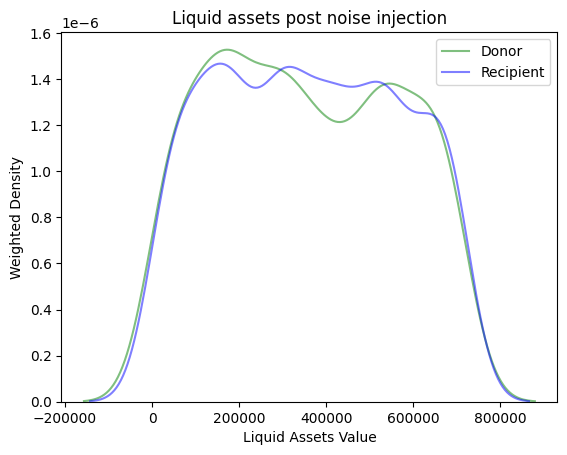

In [49]:
# Compare the input to the output in the process
plot_data = imputer.recipient_data[['weight','imp_donor_assets']]
plot_data_donor = imputer.donor_data[['weight','donor_assets']]

# Create a weighted histogram plot for donor data
sns.kdeplot(data=plot_data_donor, x='donor_assets', weights='weight', color='green', label='Donor', alpha=0.5)

# Create a weighted histogram plot for recipient data
sns.kdeplot(data=plot_data, x='imp_donor_assets', weights='weight', color='blue', label='Recipient', alpha=0.5)

# Add titles and labels
plt.title('Liquid assets post noise injection')
plt.xlabel('Liquid Assets Value')
plt.ylabel('Weighted Density')

# Add a legend to differentiate between recipient and donor data
plt.legend()

# Show the plot
plt.show()

In [50]:
imputer.gen_analysis_file('hot_deck_stats', '')

Cell data written to '.\hot_deck_stats.xlsx'.


In [51]:
imputer.gen_analysis_file('hot_deck_stats')

Cell data written to '.\hot_deck_stats.xlsx'.
